# start

In [6]:
import os
import pandas as pd
import numpy as np
import time
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
import dgl
import dgl.function as fn
import dgl.nn.pytorch as dgl_nn
import tensorflow as tf
import torch
import torch.nn as nn
from collections import defaultdict
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from rdkit.Chem.rdmolops import FastFindRings
from torch.nn import Parameter
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    

Using backend: pytorch
[16:42:35] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /root/anaconda3/lib/python3.8/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.11.0.so: cannot open shared object file: No such file or directory


In [11]:
data_file = '../data2/data2.csv'
mol_dir = '../data2/data2_sdf_files/'

In [12]:
def Nodes_feat(mol):
    
    atom_feats_dict = defaultdict(list)
    is_donor = defaultdict(int)
    is_acceptor = defaultdict(int)
    fdef_name = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
    mol.UpdatePropertyCache()
    FastFindRings(mol)
    mol_featurizer = ChemicalFeatures.BuildFeatureFactory(fdef_name)
    mol_feats = mol_featurizer.GetFeaturesForMol(mol)
    mol_conformers = mol.GetConformers()
    assert len(mol_conformers) == 1
    geom = mol_conformers[0].GetPositions()
    for i in range(len(mol_feats)):
        if mol_feats[i].GetFamily() == 'Donor':
            node_list = mol_feats[i].GetAtomIds()
            for u in node_list:
                is_donor[u] = 1
        elif mol_feats[i].GetFamily() == 'Acceptor':
            node_list = mol_feats[i].GetAtomIds()
            for u in node_list:
                is_acceptor[u] = 1
    num_atoms = mol.GetNumAtoms()
    atoms = mol.GetAtoms()
    AllChem.ComputeGasteigerCharges(mol)
    atom_types = [atom.GetAtomicNum() for atom in atoms]
    rdkit_period_table = Chem.GetPeriodicTable()
    radius = np.array([rdkit_period_table.GetRvdw(item) for item in atom_types])
    charge=[atom.GetDoubleProp('_GasteigerCharge') for atom in atoms]
    conformer = mol.GetConformer()
    positions = conformer.GetPositions()
    h_u = []    
    for u in range(num_atoms):
        ato = mol.GetAtomWithIdx(u)
        symbol = ato.GetSymbol()
        atom_type = ato.GetAtomicNum()
        aromatic = ato.GetIsAromatic()
        hybridization = ato.GetHybridization()
        num_h = ato.GetTotalNumHs()
        atom_feats_dict['pos'].append(torch.FloatTensor(geom[u]))
        atom_feats_dict['node_type'].append(atom_type)   
        h_u += [
            int(symbol == x) for x in ['H', 'C', 'N', 'O', 'F', 'S', 'Cl']
        ]
        h_u.append(atom_type)
        h_u.append(is_acceptor[u])
        h_u.append(is_donor[u])
        h_u.append(int(aromatic))
        h_u += [
            int(hybridization == x)
            for x in (Chem.rdchem.HybridizationType.SP,
                      Chem.rdchem.HybridizationType.SP2,
                      Chem.rdchem.HybridizationType.SP3)
        ]
        h_u.append(num_h)
    h_u=np.array(h_u).reshape(-1,15)
    return h_u

In [13]:
def Get_DGL(sdf_file='',rdkit_mol=None,spms_acc=40,elec_acc=10,removeHs=False,spms_radius=None):
    
    if sdf_file != '':
        if removeHs:
            mol = Chem.MolFromMolFile(sdf_file,removeHs=True,sanitize=False)
        else:
            mol = Chem.MolFromMolFile(sdf_file,removeHs=False,sanitize=False)
    elif rdkit_mol != None:
        mol = rdkit_mol
        
    atoms = mol.GetAtoms()
    atom_symbols = [atom.GetSymbol() for atom in atoms]
    bonds = mol.GetBonds()
    edges = [[bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()] for bond in bonds]
    pos = mol.GetConformer().GetPositions()
    
    G = nx.Graph()
    G.add_nodes_from(list(range(0,len(atom_symbols))))
    G.add_edges_from(edges)
    if dgl.__version__ == '0.4.3post2':
        dgl_g = dgl.graph(G)
    else:
        dgl_g=dgl.from_networkx(G)
    #dgl_g= dgl.add_self_loop(dgl_g)
    all_edges_0,all_edges_1 = dgl_g.all_edges()
    dist = np.array([np.linalg.norm(pos[int(all_edges_0[i])]-pos[int(all_edges_1[i])]) for i in range(len(all_edges_0))]).reshape(-1,1)
    dist = torch.tensor(dist,dtype=torch.float32)
    #dgl_g.ndata['feat'] = feat
    dgl_g.edata['feat'] = dist
    return dgl_g

In [34]:
def sort_func(x): return eval(x.split('/')[-1].split('.')[0].split('_')[-1])
cat_files = sorted(glob.glob('../data2/data2_sdf_files/cat_*.sdf'),key=sort_func)
imine_files = sorted(glob.glob('../data2/data2_sdf_files/imine_*.sdf'),key=sort_func)
thiol_files = sorted(glob.glob('../data2/data2_sdf_files/thiol_*.sdf'),key=sort_func)

#cat_files=[x.split('/')[-1].split('.')[0] for x in cat_files]
#imine_files=[x.split('/')[-1].split('.')[0] for x in imine_files]
#thiol_files=[x.split('/')[-1].split('.')[0] for x in thiol_files]

sdf_file=cat_files+imine_files+thiol_files
with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()
smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

In [35]:
def Calc_feat(file_list):
    
    file_graph_dict = {}
    for index, tmp_file in enumerate(file_list):
        tmp_fn = tmp_file.split('/')[-1].split('.')[0]
        tmp_g = Get_DGL(tmp_file)
        file_graph_dict[tmp_fn] = tmp_g
        #feat_name_dict[tmp_fn] = index
        mol = Chem.MolFromMolFile(tmp_file,removeHs=False)
        num_atoms = mol.GetNumAtoms()
        print(tmp_file)
        atom_feats= Nodes_feat(mol)
        atom_feats = torch.tensor(atom_feats,dtype=torch.float32)
        tmp_g.ndata['feat'] = atom_feats

    return file_graph_dict

In [36]:
imine_Graph_name_dict=Calc_feat(imine_files)

../data2/data2_sdf_files/imine_0.sdf
../data2/data2_sdf_files/imine_1.sdf
../data2/data2_sdf_files/imine_2.sdf
../data2/data2_sdf_files/imine_3.sdf
../data2/data2_sdf_files/imine_4.sdf


In [37]:
cat_Graph_name_dict=Calc_feat(cat_files)

../data2/data2_sdf_files/cat_0.sdf
../data2/data2_sdf_files/cat_1.sdf
../data2/data2_sdf_files/cat_2.sdf
../data2/data2_sdf_files/cat_3.sdf
../data2/data2_sdf_files/cat_4.sdf
../data2/data2_sdf_files/cat_5.sdf
../data2/data2_sdf_files/cat_6.sdf
../data2/data2_sdf_files/cat_7.sdf
../data2/data2_sdf_files/cat_8.sdf
../data2/data2_sdf_files/cat_9.sdf
../data2/data2_sdf_files/cat_10.sdf
../data2/data2_sdf_files/cat_11.sdf
../data2/data2_sdf_files/cat_12.sdf
../data2/data2_sdf_files/cat_13.sdf
../data2/data2_sdf_files/cat_14.sdf
../data2/data2_sdf_files/cat_15.sdf
../data2/data2_sdf_files/cat_16.sdf
../data2/data2_sdf_files/cat_17.sdf
../data2/data2_sdf_files/cat_18.sdf
../data2/data2_sdf_files/cat_19.sdf
../data2/data2_sdf_files/cat_20.sdf
../data2/data2_sdf_files/cat_21.sdf
../data2/data2_sdf_files/cat_22.sdf
../data2/data2_sdf_files/cat_23.sdf
../data2/data2_sdf_files/cat_24.sdf
../data2/data2_sdf_files/cat_25.sdf
../data2/data2_sdf_files/cat_26.sdf
../data2/data2_sdf_files/cat_27.sdf
..

In [38]:
thiol_Graph_name_dict=Calc_feat(thiol_files)

../data2/data2_sdf_files/thiol_0.sdf
../data2/data2_sdf_files/thiol_1.sdf
../data2/data2_sdf_files/thiol_2.sdf
../data2/data2_sdf_files/thiol_3.sdf
../data2/data2_sdf_files/thiol_4.sdf


In [60]:
np.save( './Denmark_DataSet/cat_Graph_name_dict.npy',cat_Graph_name_dict)
np.save( './Denmark_DataSet/imine_Graph_name_dict.npy',imine_Graph_name_dict)
np.save( './Denmark_DataSet/thiol_Graph_name_dict.npy',thiol_Graph_name_dict)

# load data

In [36]:
cat_Graph_name_dict=np.load( './Denmark_DataSet/cat_Graph_name_dict.npy',allow_pickle=True).item()
imine_Graph_name_dict=np.load( './Denmark_DataSet/imine_Graph_name_dict.npy',allow_pickle=True).item()
thiol_Graph_name_dict=np.load( './Denmark_DataSet/thiol_Graph_name_dict.npy',allow_pickle=True).item()

In [39]:
class Graph_DataSet(Dataset):

    def __init__(self, root, train=True, transform = None, target_transform=None):
        super(Graph_DataSet, self).__init__()
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        #如果是训练则加载训练集，如果是测试则加载测试集
        if self.train :
            file_annotation = root + '/data2.csv' 
            sdf_folder = root + '/data2_sdf_files/'
        else:
            file_annotation = root + '/test.csv' 
            sdf_folder = root + '/test_sdf/'
        df = pd.read_csv(file_annotation)
 
        #data_dict = df[['molecule','CV']]
        target = np.array(df['Output'].to_list())
        self.target_min = target.min()
        self.target_range = target.max() - target.min()
        
        target_std = (target - target.min())/(target.max()-target.min())
        
        cat_smi = df['Catalyst'].to_list()
        imine_smi = df['Imine'].to_list()
        thiol_smi = df['Thiol'].to_list()
        
        
        cat_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in cat_smi]
        imine_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in imine_smi]
        thiol_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in thiol_smi]
        
        self.cat_file_names = cat_file_names
        self.imine_file_names = imine_file_names
        self.thiol_file_names = thiol_file_names
        
        self.target_std = target_std
        self.sdf_folder = sdf_folder
            
    def __getitem__(self, index):
        #mol_name = self.filenames[index]
        cat_name = self.cat_file_names[index]
        imine_name = self.imine_file_names[index]
        thiol_name = self.thiol_file_names[index]
        label = self.target_std[index]

        graph_1 = cat_Graph_name_dict[cat_name]
        graph_2 = imine_Graph_name_dict[imine_name]
        graph_3 = thiol_Graph_name_dict[thiol_name]
        
        return [graph_1,graph_1.ndata['feat'],graph_2,graph_2.ndata['feat'],graph_3,graph_3.ndata['feat']], label

    def __len__(self):
        return len(self.target_std)

# GCN

In [40]:
class StochasticTwoLayerGCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()      
        
        #self.conv1 = dgl.nn.SGConv(in_features, hidden_features,  k=2, cached=True)
        #self.conv2 = dgl.nn.SGConv(hidden_features, hidden_features, k=2, cached=True)
        #self.conv3 = dgl.nn.SGConv(hidden_features, hidden_features, k=2, cached=True)
        
        #self.conv1 = dgl.nn.SAGEConv(in_features, hidden_features, 'pool')
        #self.conv2 = dgl.nn.SAGEConv(hidden_features, hidden_features, 'pool')
        #self.conv3 = dgl.nn.SAGEConv(hidden_features, hidden_features, 'pool')
                
        #self.conv1 = dgl.nn.EdgeConv(in_features, hidden_features)
        #self.conv2 = dgl.nn.EdgeConv(hidden_features, hidden_features)
        #self.conv3 = dgl.nn.EdgeConv(hidden_features, hidden_features)
        
        #self.conv1 = dgl.nn.GATConv(in_features, hidden_features, num_heads=3)
        #self.conv2 = dgl.nn.GATConv(hidden_features, hidden_features, num_heads=3)
        #self.conv3 = dgl.nn.GATConv(hidden_features, hidden_features, num_heads=3)
        
        #self.conv1 = dgl.nn.TAGConv(in_features, hidden_features, k=4)
        #self.conv2 = dgl.nn.TAGConv(hidden_features, hidden_features, k=4)
        #self.conv3 = dgl.nn.TAGConv(hidden_features, hidden_features, k=4)
        
        #self.conv1 = dgl.nn.RelGraphConv(in_features, hidden_features, 4, num_bases=4)
        #self.conv2 = dgl.nn.RelGraphConv(hidden_features, hidden_features,4 , num_bases=4)
        #self.conv3 = dgl.nn.RelGraphConv(hidden_features, hidden_features,4, num_bases=4)
        #etype = np.ones(186).astype(np.int64)
        
        self.conv1 = dgl.nn.GraphConv(in_features, hidden_features)
        self.conv2 = dgl.nn.GraphConv(hidden_features, hidden_features)
        #self.conv3 = dgl.nn.GraphConv(hidden_features, hidden_features)
       
        self.fc1   = nn.Linear(304,128) 
        self.fc2   = nn.Linear(128, 64)
        self.fc3   = nn.Linear(64, 1)

    def forward(self,g1,x1,g2,x2,g3,x3,multi_graph_opt='mean',output_opt='mean'):
        
        x1 = F.relu(self.conv1(g1, x1))
        x1 = F.relu(self.conv2(g1, x1))
        #x1 = F.relu(self.conv3(g1, x1))
        #x1=torch.mean(x1,axis=0).reshape(-1,1)
        #x1t=x1.transpose(-1,0)
        #x1t=x1.reshape(-1,200)
       
        x2 = F.relu(self.conv1(g2, x2))
        x2 = F.relu(self.conv2(g2, x2))
        #x2 = F.relu(self.conv3(g2, x2))
        #x2=torch.mean(x2,axis=0).reshape(-1,1)
        #x2t=x2.transpose(-1,0)
        #x2t=x2.reshape(-1,200)
        
        x3 = F.relu(self.conv1(g3, x3))
        x3 = F.relu(self.conv2(g3, x3))
        #x3 = F.relu(self.conv3(g3, x3))
        #x3=torch.mean(x3,axis=0).reshape(-1,1)
        #x3t=x3.transpose(-1,0)
        #x3t=x3.reshape(-1,200)
        
        
        if multi_graph_opt == 'mean':
            x = torch.mean(torch.cat([x1,x2,x3],axis=0),axis=0)
           
        elif multi_graph_opt == 'sum':
            x = torch.sum(torch.cat([x1,x2,x3],axis=0),axis=0)
        
        if output_opt == 'mean':
            x = F.torch.mean(x)
        elif output_opt == 'sum':
            x = F.torch.sum(x)
        '''x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))'''
        
        return x

## RANDOM

In [41]:
loss = 'mse'
batch_size = 128
shuffle = np.array(list(range(1075)))
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
dataset = Graph_DataSet('../data2')
train_data=[]
for i in train_index:
    tem_data=dataset[i]
    train_data.append(tem_data)
    
val_data=[]
for i in val_index:
    tem_data=dataset[i]
    val_data.append(tem_data)     

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
model = StochasticTwoLayerGCN(15,256,1)
#optimizer = optim.Adam(model.parameters())
#loss_func = torch.nn.L1Loss()
optimizer = optim.Adam(model.parameters())
loss_func = torch.nn.L1Loss()

checkpoint=ModelCheckpoint("../Dataset/run_data/model_cusgraph.hdf5",
                               verbose=0,monitor='loss',
                               save_best_only=True,mode='min')

for epoch in range(50):
    get_output=[]
    all_loss = []
    model.train()
    for i, data in enumerate(train_data):
        inputs, labels = data

        # zero the parameter gradients
        

        # forward + backward + optimize
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        get_output.append(outputs)

        labels = torch.tensor(labels) 
        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print('Train MSE',np.mean(all_loss))
    model.eval()
    test_get_output=[]
    test_all_labels = []
    all_loss = []
    for data in val_data:
        inputs, labels = data
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        test_get_output.append(outputs)
        labels = torch.tensor(labels) 
        test_all_labels.append(labels)
        loss = loss_func(outputs, labels)
        all_loss.append(loss.detach().numpy())
    print('Test MSE',np.mean(all_loss))   

#hist = model.fit_generator(train_data,validation_data=val_data,epochs=100,callbacks=[checkpoint])

Train MSE 0.17438026
Test MSE 0.1572591
Train MSE 0.17097642
Test MSE 0.16240966
Train MSE 0.16765334
Test MSE 0.15535648
Train MSE 0.16274041
Test MSE 0.14540526
Train MSE 0.15874916
Test MSE 0.14264765
Train MSE 0.15619446
Test MSE 0.13698292
Train MSE 0.15437634
Test MSE 0.13953103
Train MSE 0.15357487
Test MSE 0.13604131
Train MSE 0.1520902
Test MSE 0.13440403
Train MSE 0.15116869
Test MSE 0.13351265
Train MSE 0.15018424
Test MSE 0.13252789
Train MSE 0.14973892
Test MSE 0.13204284
Train MSE 0.14854655
Test MSE 0.13183402
Train MSE 0.14722592
Test MSE 0.12930253
Train MSE 0.1463546
Test MSE 0.12844737
Train MSE 0.1460037
Test MSE 0.12883615
Train MSE 0.14427818
Test MSE 0.12749885
Train MSE 0.1440815
Test MSE 0.12663841
Train MSE 0.14271706
Test MSE 0.1237747
Train MSE 0.14110552
Test MSE 0.124525934
Train MSE 0.14111345
Test MSE 0.121895365
Train MSE 0.14021981
Test MSE 0.121370174
Train MSE 0.1398437
Test MSE 0.12145654
Train MSE 0.13740882
Test MSE 0.119585544
Train MSE 0.1366495

In [90]:
test_all_labels_=[]
for i in test_all_labels:
    test_all_labels_.append(i.tolist())
    
test_get_output_=[]
for i in test_get_output:
    test_get_output_.append(i.tolist())

In [91]:
tmp_df = pd.read_csv(data_file)
labels_ori = np.array(tmp_df['Output'].to_list())

In [92]:
y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()

In [2]:
(0.561+0.562+0.560+0.554+0.555+0.551+0.551+0.552+0.548+0.552)/10

0.5546000000000001

In [3]:
(0.260+0.257+0.264+0.279+0.275+0.286+0.286+0.283+0.294+0.284)/10

0.2768

In [94]:
np.save( './Denmark_DataSet/denmark_15_GCN_y_val.npy',y_val)
np.save( './Denmark_DataSet/denmark_15_GCN_y_pred.npy',y_pred)

In [1]:
y_val=np.load('./Baseline_SE_GCN/run_data/denmark_15_GCN_y_val.npy')
y_pred=np.load('./Baseline_SE_GCN/run_data/denmark_15_GCN_y_pred.npy')

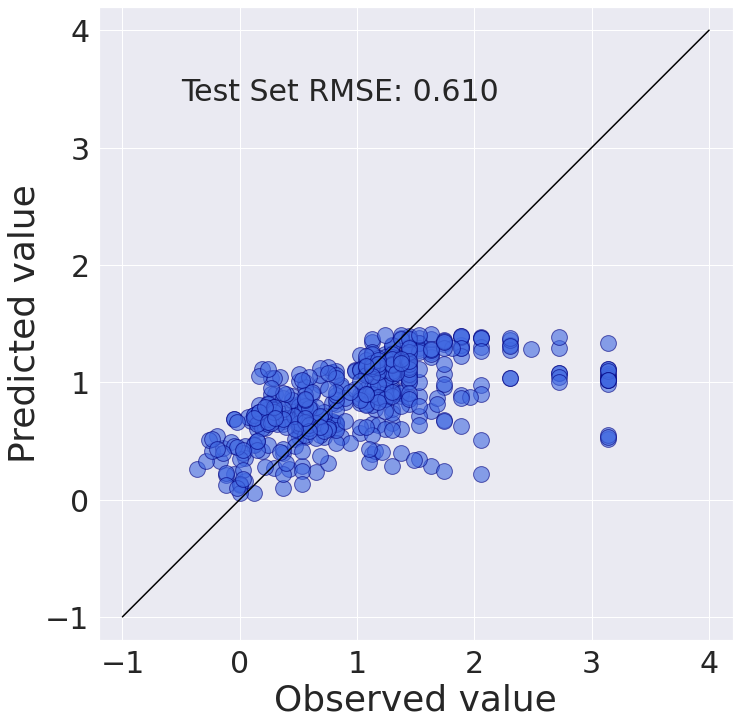

In [4]:
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
sns.set(style='darkgrid')


#display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(11,11),facecolor='white',    # 图表区的背景色
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,4],[-1,4],c='black')
'''x = np.arange(-1,5)
y = x
l = plt.plot(x,y)
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.fill_between(x,x+0.5,x-0.5,alpha=0.2,color='yellow')'''
plt.xlim(-1.2,4.2)
plt.ylim(-1.2,4.2)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax.set_facecolor('')#oldlace   mistyrose
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
#plt.title('doyle',fontsize=14)
plt.xlabel("Observed value",fontsize=36)
plt.ylabel("Predicted value",fontsize=36)
#plt.grid(c='white', linewidth=2)
plt.tick_params(labelsize=30)
plt.text(-0.5,3.4,'Test Set RMSE: %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
#plt.text(-0.5,3.4,'Test Set R2: %.3f'%r2_score(y_val,y_pred),fontsize=24)


plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()
#fig.savefig('./Dataset/denmark_random_fig.png',dpi=400)
#depth4   hidden_size128,0.244   256  0.225
#depth3    hidden_size128       5   128   0.247  5   256   0.224